In [15]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import nn, Tensor
import torch.nn.init as init
from typing import Callable, Tuple
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import gc

_scaling_min = 0.001

torch.set_default_dtype(torch.float64)

def unsqueeze(x):
    return x.unsqueeze(0).unsqueeze(-1).detach()

class ActNorm(torch.nn.Module):
    """
    ActNorm layer
    """
    
    def __init__(self,
                 num_features: int, # number of input dimension
                 logscale_factor: float = 1.,
                 scale: float = 1.,
                 learn_scale: bool = True
                 ) -> None:
        super(ActNorm, self).__init__()

        self.initialized = False
        self.num_features = num_features

        self.register_parameter('b', nn.Parameter(torch.zeros(1, num_features, 1), requires_grad=True))
        self.learn_scale = learn_scale
        if learn_scale:
            self.logscale_factor = logscale_factor
            self.scale = scale
            self.register_parameter('logs', nn.Parameter(torch.zeros(1, num_features, 1), requires_grad=True))
            
    def forward_transform(self, x, logdet=0):
        input_shape = x.size()
        x = x.view(input_shape[0], input_shape[1], -1)

        if not self.initialized:
            self.initialized = True
            
            sum_size = x.size(0) * x.size(-1)
            b = -torch.sum(x, dim=(0, -1)) / sum_size
            self.b.data.copy_(unsqueeze(b).data)

            if self.learn_scale:
                var = unsqueeze(torch.sum((x + unsqueeze(b)) ** 2, dim=(0, -1)) / sum_size)
                logs = torch.log(self.scale / (torch.sqrt(var) + 1e-6)) / self.logscale_factor
                self.logs.data.copy_(logs.data)

        b = self.b
        output = x + b

        if self.learn_scale:
            logs = self.logs * self.logscale_factor
            scale = torch.exp(logs) + _scaling_min
            output = output * scale
            dlogdet = torch.sum(torch.log(scale)) * x.size(-1)  # c x h

            return output.view(input_shape), logdet + dlogdet
        else:
            return output.view(input_shape), logdet

class ActNormNoLogdet(ActNorm):

    def forward(self, x):
        return super(ActNormNoLogdet, self).forward_transform(x)[0]

class SequentialFlow(torch.nn.Module):

    def __init__(self, flows):
        super(SequentialFlow, self).__init__()
        self.flows = torch.nn.ModuleList(flows)

    def forward_transform(self, x, logdet=0):
        for flow in self.flows:
            x, logdet = flow.forward_transform(x, logdet)
        return x, logdet



def symm_softplus(x, softplus_=torch.nn.functional.softplus):
    return softplus_(x) - 0.5 * x


def softplus(x):
    return nn.functional.softplus(x)


def gaussian_softplus(x):
    z = np.sqrt(np.pi / 2)
    return (z * x * torch.erf(x / np.sqrt(2)) + torch.exp(-x**2 / 2) + z * x) / (2*z)


def gaussian_softplus2(x):
    z = np.sqrt(np.pi / 2)
    return (z * x * torch.erf(x / np.sqrt(2)) + torch.exp(-x**2 / 2) + z * x) / z


def laplace_softplus(x):
    return torch.relu(x) + torch.exp(-torch.abs(x)) / 2


def cauchy_softplus(x):
    # (Pi y + 2 y ArcTan[y] - Log[1 + y ^ 2]) / (2 Pi)
    pi = np.pi
    return (x * pi - torch.log(x**2 + 1) + 2 * x * torch.atan(x)) / (2*pi)


def activation_shifting(activation):
    def shifted_activation(x):
        return activation(x) - activation(torch.zeros_like(x))
    return shifted_activation


def get_softplus(softplus_type='softplus', zero_softplus=False):
    if softplus_type == 'softplus':
        act = nn.functional.softplus
    elif softplus_type == 'gaussian_softplus':
        act = gaussian_softplus
    elif softplus_type == 'gaussian_softplus2':
        act = gaussian_softplus2
    elif softplus_type == 'laplace_softplus':
        act = gaussian_softplus
    elif softplus_type == 'cauchy_softplus':
        act = cauchy_softplus
    else:
        raise NotImplementedError(f'softplus type {softplus_type} not supported.')
    if zero_softplus:
        act = activation_shifting(act)
    return act


class Softplus(nn.Module):
    def __init__(self, softplus_type='softplus', zero_softplus=False):
        super(Softplus, self).__init__()
        self.softplus_type = softplus_type
        self.zero_softplus = zero_softplus

    def forward(self, x):
        return get_softplus(self.softplus_type, self.zero_softplus)(x)


class SymmSoftplus(torch.nn.Module):

    def forward(self, x):
        return symm_softplus(x)


class PosLinear(torch.nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        gain = 1 / x.size(1)
        return nn.functional.linear(x, torch.nn.functional.softplus(self.weight), self.bias) * gain


class PosLinear2(torch.nn.Linear):
    def forward(self, x: Tensor) -> Tensor:
        return nn.functional.linear(x, torch.nn.functional.softmax(self.weight, 1), self.bias)


class PosConv2d(torch.nn.Conv2d):

    def reset_parameters(self) -> None:
        super().reset_parameters()
        # noinspection PyProtectedMember,PyAttributeOutsideInit
        self.fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)

    def forward(self, x: Tensor) -> Tensor:
        return self._conv_forward(x, torch.nn.functional.softplus(self.weight)) / self.fan_in



class ICNN(torch.nn.Module):
    def __init__(self, dim=2, dimh=16, num_hidden_layers=1):
        super(ICNN, self).__init__()

        Wzs = list()
        Wzs.append(nn.Linear(dim, dimh))
        for _ in range(num_hidden_layers - 1):
            Wzs.append(PosLinear(dimh, dimh, bias=False))
        Wzs.append(PosLinear(dimh, 1, bias=False))
        self.Wzs = torch.nn.ModuleList(Wzs)

        Wxs = list()
        for _ in range(num_hidden_layers - 1):
            Wxs.append(nn.Linear(dim, dimh))
        Wxs.append(nn.Linear(dim, 1, bias=False))
        self.Wxs = torch.nn.ModuleList(Wxs)
        self.act = nn.Softplus()

    def forward(self, x):
        z = self.act(self.Wzs[0](x))
        for Wz, Wx in zip(self.Wzs[1:-1], self.Wxs[:-1]):
            z = self.act(Wz(z) + Wx(x))
        return self.Wzs[-1](z) + self.Wxs[-1](x)





class ICNN3(torch.nn.Module):
    def __init__(self, 
                 dim: int = 2, # input dimension 
                 dimh: int = 16, # hidden layer dimension
                 num_hidden_layers: int = 2, # number of hidden layer 
                 symm_act_first: bool = False, # refer to the paper
                 softplus_type: str = 'softplus', # refer to the paper
                 zero_softplus: bool = False # refer to the paper
                 ) -> None:
        super(ICNN3, self).__init__()

        self.act = Softplus(softplus_type=softplus_type, zero_softplus=zero_softplus)
        self.symm_act_first = symm_act_first

        Wzs = list()
        Wzs.append(nn.Linear(dim, dimh))
        for _ in range(num_hidden_layers - 1):
            Wzs.append(PosLinear(dimh, dimh // 2, bias=True))
        Wzs.append(PosLinear(dimh, 1, bias=False))
        self.Wzs = torch.nn.ModuleList(Wzs)

        Wxs = list()
        for _ in range(num_hidden_layers - 1):
            Wxs.append(nn.Linear(dim, dimh // 2))
        Wxs.append(nn.Linear(dim, 1, bias=False))
        self.Wxs = torch.nn.ModuleList(Wxs)

        Wx2s = list()
        for _ in range(num_hidden_layers - 1):
            Wx2s.append(nn.Linear(dim, dimh // 2))
        self.Wx2s = torch.nn.ModuleList(Wx2s)

        actnorms = list()
        for _ in range(num_hidden_layers - 1):
            actnorms.append(ActNormNoLogdet(dimh // 2))
        actnorms.append(ActNormNoLogdet(1))
        actnorms[-1].b.requires_grad_(False)
        self.actnorms = torch.nn.ModuleList(actnorms)

    def forward(self, x):
        if self.symm_act_first:
            z = symm_softplus(self.Wzs[0](x), self.act)
        else:
            z = self.act(self.Wzs[0](x))
        for Wz, Wx, Wx2, actnorm in zip(self.Wzs[1:-1], self.Wxs[:-1], self.Wx2s[:], self.actnorms[:-1]):
            z = self.act(actnorm(Wz(z) + Wx(x)))
            aug = Wx2(x)
            aug = symm_softplus(aug, self.act) if self.symm_act_first else self.act(aug)
            z = torch.cat([z, aug], 1)
        return self.actnorms[-1](self.Wzs[-1](z) + self.Wxs[-1](x))



class DeepConvexFlow(torch.nn.Module):
    def __init__(self, 
                 icnn: Callable[..., Tensor], # ICNN object
                 bias_w1: float = 0.0, # bias parameters in actnorm layer
                 trainable_w0: bool = True # weight parameters in actnorm layer
                 ) -> None:
        super(DeepConvexFlow, self).__init__()

        self.icnn = icnn
        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)

        
    def get_potential(self, 
                      x: Tensor
                      ) -> Tensor:
        """compute the potential F

        Args:
            x (Tensor): coordinates

        Returns:
            Tensor: potential F (N, 1)
        """
        n = x.size(0)
        icnn = self.icnn(x)
        return F.softplus(self.w1) * icnn + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2
    
    def forward(self, 
                x: Tensor
                ) -> Tensor:
        """forward function, compute the convex potential f, gradient of F

        Args:
            x (Tensor): coordinate

        Returns:
            Tensor: convex potential, f (N, d)
        """
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f
    
    def forward_transform(self, 
                          x: Tensor, 
                          logdet: Tensor = 0
                          ) -> Tuple[Tensor, Tensor]:
        """compute the convex potential f and log determinant

        Args:
            x (Tensor): coordinate
            logdet (Tensor, optional): log determinant (N, 1). Defaults to 0.

        Returns:
            Tuple[Tensor, Tensor]: convex potential, log determinant
        """
        
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
            H = []
            
            for i in range(f.shape[1]):
                H.append(torch.autograd.grad(f[:, i].sum(), x, create_graph = True, retain_graph = True)[0])
                
            H = torch.stack(H, dim = 1)
        
        return f, logdet + torch.slogdet(H).logabsdet



def V(phi: Tensor,
      mu: Tensor,
      sigma: Tensor) -> Tensor:
    """
    Applied bilinear transformation on the each row of the input
    V(x) = 1/2 * (x - \mu)^T \Sigma^{-1} (x - \mu)

    Args:
        phi (Tensor [N, d]): normalizing flow output
        mu (Tensor [1, d]): mean vector
        sigma (Tensor [d, d]): covariance matrix
    
    Return:
        Tensor [N, 1]
    """
    x_cen = phi - mu
    return 0.5 * torch.sum(torch.mm(x_cen, torch.inverse(sigma))*x_cen, 1, keepdim=True)

def MulNormal(mu: Tensor,
              sigma: Tensor,
              pos: Tensor) -> Tensor:
    """Genrate the density for multivariate gaussian distribution

    Args:
        mu (Tensor): mean vector
        sigma (Tensor): sigma matrix
        pos (Tensor): position for density evaluation

    Returns:
        Density (Tensor): density at position
    """
    rv = multivariate_normal(mu, sigma)
    return torch.from_numpy(rv.pdf(pos)).unsqueeze_(1)



class OOMFormatter(ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

def DensityPlot(x, y, rho, t, s):
    _, ax = plt.subplots(figsize=(10, 10))
    h = ax.scatter(x, y, c = rho, alpha=1, cmap= 'viridis',  marker='o', s=10)
    ax.grid(color='grey', linestyle='-', linewidth=0.25)
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(h, cax=cax, format=OOMFormatter(-1, mathText=False)).ax.yaxis.offsetText.set_fontsize(30)
    plt.tick_params(labelsize=30)
    ax.set_xlim([xmin-0.1, xmax+0.1])
    ax.set_ylim([ymin-0.1, ymax+0.1])
    ax.tick_params(axis='both', which='major', labelsize=30)
    plt.savefig('./' + f'fokker4d' + s + 'phase' + f'{t}.png', pad_inches = 0.05, bbox_inches='tight')
    plt.show()
    plt.close()
    


def FokkerPlanck(phi: Tensor,
                 coor: Tensor,
                 rho: Tensor,
                 lgdet: Tensor,
                 V:Tensor
                 ) -> Tensor:
    """Loss function for Fokker Planck equation

    Args:
        phi (Tensor): The convex potential of the normalizing flow [N, d]
        coor (Tensor): Input data [N, d]
        rho (Tensor): Estimated function [N, 1] 
        lgdet (Tensor): Log determinant [N, 1]
        V (Tensor): density [N, 1]

    Returns:
        loss
    """
    Cap_Phi = 50*torch.mean(rho*torch.sum((phi - coor)**2, dim = 1, keepdim = True)) # captical phi
    vol = torch.mean(rho * (torch.log(rho) - lgdet.unsqueeze_(-1) + V)) # second part
    
    return Cap_Phi + vol, vol

In [24]:
dimx = 4
depth = 6
k = 32
symm_act_first = True
zero_softplus = False
softplus_type = 'gaussian_softplus2'
abserror = []
relativeerror = []
ENERGY = []


mu = torch.tensor([1/3, 1/3, 0, 0])
# sigma = torch.tensor([[5/8, -3/8, 0, 0], [-3/8, 5/8, 0, 0], [0, 0, 5/8, -3/8], [0, 0, -3/8, 5/8]])
sigma = torch.tensor([[5/8, -3/8, 0, 0], [-3/8, 5/8, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


mu0 = torch.tensor([0, 0, 0, 0])
sigma0 = torch.tensor([[1 , 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

x, y, z, u = np.random.multivariate_normal(mu0, sigma0, 10000).T
x, y, z, u = torch.from_numpy(x).unsqueeze_(1), torch.from_numpy(y).unsqueeze_(1), torch.from_numpy(z).unsqueeze_(1), torch.from_numpy(u).unsqueeze_(1)
coor = torch.cat((x, y, z, u), dim = 1)
rho = MulNormal(mu0, sigma0, coor)



nblocks = 1
icnns = [ICNN3(dimx, k, depth, symm_act_first=symm_act_first, softplus_type=softplus_type, zero_softplus=zero_softplus) for _ in range(nblocks)]
layers = [None] * (nblocks + 1)
layers[0] = ActNorm(dimx)
layers[1:] = [DeepConvexFlow(icnn, bias_w1=-0.0, trainable_w0=False) for _, icnn in zip(range(nblocks), icnns)]

IDENTICAL = SequentialFlow(layers)
flow = SequentialFlow(layers)

In [ ]:
print('x1 and x2 phase')
DensityPlot(coor.numpy()[:,0], coor.numpy()[:,1], rho, 0, 'x1x2')
print('x3 and x4 phase')
DensityPlot(coor.numpy()[:,2], coor.numpy()[:,3], rho, 0, 'x3x4')

In [26]:
def Identity(phi, coor):
    return torch.mean(torch.sum((phi - coor)**2, dim = 1, keepdim = True))

def FokkerPretrain(model, coor):
    # x = torch.linspace(-3, 3, 10)
    # y = torch.linspace(-3, 3, 10)
    # u = torch.linspace(-3, 3, 10)
    # z = torch.linspace(-3, 3, 10)
    # X, Y, U, Z = torch.meshgrid(x, y, u, z)
    # coor = torch.cat((X.flatten()[:, None], Y.flatten()[:, None], U.flatten()[:, None], Z.flatten()[:, None]), dim=1)

    optimizer = torch.optim.LBFGS(model.parameters(),
                            history_size = 50,
                            max_iter = 50,
                            line_search_fn= 'strong_wolfe')
    def closure():
        optimizer.zero_grad()
        phi, lgdet = model.forward_transform(coor)
        loss = Identity(phi, coor)
        loss.backward()
        return loss

    optimizer.step(closure)


FokkerPretrain(IDENTICAL, coor)

# gc.collect()

new, lgd = IDENTICAL.forward_transform(coor)
flow.load_state_dict(IDENTICAL.state_dict())
print(Identity(new, coor))


tensor(6.1726e-06, grad_fn=<MeanBackward0>)


In [27]:
print(new)
print('==========')
print(coor)

tensor([[-0.7311,  0.1254, -0.1722,  0.7502],
        [-0.0136, -0.4161,  1.2133,  1.8655],
        [ 0.2221, -1.3303, -0.0870,  1.4748],
        ...,
        [-0.6003, -1.2963,  0.3312, -0.3242],
        [-0.5049, -0.9717,  2.5736,  0.4185],
        [ 0.6274,  0.8074,  0.7387,  0.6714]], grad_fn=<AddBackward0>)
tensor([[-0.7306,  0.1245, -0.1715,  0.7506],
        [-0.0132, -0.4161,  1.2134,  1.8642],
        [ 0.2214, -1.3297, -0.0870,  1.4738],
        ...,
        [-0.5990, -1.2949,  0.3308, -0.3222],
        [-0.5039, -0.9709,  2.5712,  0.4198],
        [ 0.6273,  0.8063,  0.7396,  0.6705]])


In [ ]:


for epoch in range(100):
    t = 0.01*(epoch + 1)
    shift = (1 - math.exp(-4*t))
    mt = torch.tensor([1/3 * shift, 1/3 * shift, 0, 0])
    # sigt = torch.tensor([[5/8 + 3/8 * math.exp(-8*t), -3/8 + 3/8 * math.exp(-8*t), 0, 0], [-3/8 + 3/8 * math.exp(-8*t), 5/8 + 3/8 * math.exp(-8*t), 0, 0], [0, 0, 5/8 + 3/8 * math.exp(-8*t), -3/8 + 3/8 * math.exp(-8*t)], [0, 0, -3/8 + 3/8 * math.exp(-8*t), 5/8 + 3/8 * math.exp(-8*t)]])
    sigt = torch.tensor([[5/8 + 3/8 * math.exp(-8*t), -3/8 + 3/8 * math.exp(-8*t), 0, 0], [-3/8 + 3/8 * math.exp(-8*t), 5/8 + 3/8 * math.exp(-8*t), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    
    # print(epoch)
    optimizer = torch.optim.LBFGS(flow.parameters(),
                            history_size=50,
                            max_iter = 50,
                            line_search_fn= 'strong_wolfe')
    def closure():
        optimizer.zero_grad()
        phi, lgdet = flow.forward_transform(coor)
        loss = FokkerPlanck(phi, coor, rho, lgdet, V(phi, mu, sigma))[0]
        loss.backward()
        return loss

    optimizer.step(closure)

    phi, lgdet = flow.forward_transform(coor)
    with torch.no_grad():
        energy = FokkerPlanck(phi, coor, rho, lgdet, V(phi, mu, sigma))[1]
        ENERGY.append(energy.item())

    coor = phi.clone().detach()
    # coor = coor.detach()
    # lgdet = lgdet.unsqueeze_(-1).detach()
    lgdet = lgdet.detach()
    rho = rho / (torch.exp(lgdet) + 1e-8)


    act_val = MulNormal(mt, sigt, coor)
    aberr = torch.mean((rho - act_val)**2)
    abserror.append(aberr.item())
    err = torch.mean((rho - act_val)**2)/torch.mean(act_val**2)
    relativeerror.append(err.item())

    print(f'in epoch {epoch}, the L2 relative error is {err.item()}')
    print('x1 and x2 phase')
    DensityPlot(coor.numpy()[:,0], coor.numpy()[:,1], rho, epoch+1, 'x1x2')
    print('x3 and x4 phase')
    DensityPlot(coor.numpy()[:,2], coor.numpy()[:,3], rho, epoch+1, 'x3x4')
    torch.save(coor, f'./fokker4dcoor{epoch+1}.pt')
    torch.save(rho, f'./fokker4drho{epoch+1}.pt')
    flow.load_state_dict(IDENTICAL.state_dict())


In [ ]:
torch.mean(act_val**2)

tensor(0.0001)

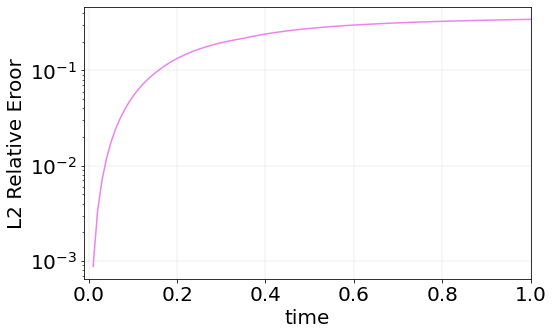

In [34]:

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# ax.set_title(r'$f = 2\sin{x}\cdot\cos{y}$')
interval = list(range(1,101))
interval = [0.01*ele for ele in interval]
# val = [abs(ele) for ele in ENERGY]
# lines = []
ax.set_yscale('log')
lines = ax.plot(interval, relativeerror,  color= '#EE82EE' )
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_xlabel('time', fontsize = 20)
ax.set_ylabel('L2 Relative Eroor', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlim([-0.01, 1])
plt.savefig('./Fokker4dL2Relative.png',pad_inches = 0.05, bbox_inches='tight')
plt.show()
plt.close()

In [35]:
torch.save(abserror, './fokker4dabserr.pt')
torch.save(relativeerror, './fokker4drelerr.pt')

In [ ]:
!zip -r /content/file.zip /content/fokker4d

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>